In [1]:
#@title Import Modules
import math
import functools
import random

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from collections import Counter
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

In [9]:
#@title Define Hyperparameters
device          = 'cuda' #'cpu'

# Experiment parameters
tasks           = [[0,2], [5,6], [3,8]]
numOutput       = len(sum(tasks, []))
num_PCA         = 64
storage_size    = 4096
dataset         = datasets.MNIST
transform       = transforms.ToTensor()
test_batch_size = 512

# Offline Parameters
epochs          = 10
offline_lr      = 7e-2
milestones      = [epochs//2]
gamma           = 0.5
batch_size      = storage_size // 8
momentum        = 0
weight_decay    = 0

# Online Parameters
online_lr       = 7e-4

# Mutual Information Parameters
n_bins          = 10

In [3]:
pca_components = 12

#@title Data Retrieval
def process_data(data, task):
    conditions = []
    for c in task:
      conditions.append((data.targets == c))
    indices = functools.reduce(torch.logical_or, conditions)
    data.data, data.targets = data.data[indices], data.targets[indices]
    for i in range(len(task)):
      data.targets[data.targets == task[i]] = i
    data = TensorDataset(data.data.reshape(-1, 28*28), data.targets)
    return data

def get_loaders(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)
    test_dataset  = process_data(dataset('../data', download=True, train=False, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
    test_dataset.tensors  = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])

    # Make dataset loaders
    online_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, drop_last=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False
    )
    return online_loader, test_loader

def get_test_loader(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)
    test_dataset  = process_data(dataset('../data', download=True, train=False, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
    test_dataset.tensors  = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])
    test_loader   = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False
    )
    return test_loader

def get_MI_loader(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])

    # Make dataset loaders
    MI_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=len(train_dataset), shuffle=False, drop_last=False
    )
    return MI_loader

In [4]:
def test_tasks(model, class_heads, tasks):
    # test tasks individually
    model.eval()
    test_set_accuracy = {}
    for taskNum in range(len(tasks)):
        print("        Testing task:", taskNum+1, "/", len(tasks), end=": ")
        test_loader = get_test_loader(tasks[taskNum])
        N = 0
        accuracy = 0
        for batch_idx, (images, labels) in enumerate(test_loader, start=1):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            h1, h2, h3, h4, h5 = model(images)
            h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)

            # check if predicted labels are equal to true labels
            predicted_labels = torch.argmax(h6,dim=1)
            accuracy += torch.sum((predicted_labels==labels).float()).item()
            N += images.shape[0]
        print(str(round(100. * accuracy/N)) + "%")
        test_set_accuracy[taskNum] = 100. * accuracy/N

    print("        Testing global accuracy: ", end="")

    N = 0
    accuracy = 0
    for taskNum, task in enumerate(tasks):
      test_loader = get_test_loader([c for c in task])
      for batch_idx, (images, labels) in enumerate(test_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5 = model(images)
        h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

    print(str(round(100. * accuracy/N)) + "%")
    total_accuracy = 100. * accuracy/N
    return total_accuracy, test_set_accuracy

In [5]:
#@title Mutual Information Computer
def compute_mutual_information(model, class_heads, taskNum, data_loader):
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

    h_list = model(images)
    h6 = F.log_softmax(class_heads[taskNum](h_list[-1]), dim = 1)
    h_list = h_list + (h6, )

    # calculate mutual information
    layers = len(h_list)
    MI_XH = torch.zeros(layers)
    MI_YH = torch.zeros(layers)
    for layer, h in enumerate(h_list):
        # discretize images and representations
        bins = np.linspace(0, 1, n_bins+1)
        x_ = np.digitize(images.cpu(), bins)
        if layer == layers-1:
            h = torch.exp(h)
            bins = np.linspace(0, 1, n_bins+1)
        else:
            bins = np.linspace(-1, 1, n_bins+1)
        h_ = np.digitize(h.cpu().detach().numpy(), bins)
        y_ = labels.cpu()

        # calculate discrete probabilities
        p_X = Counter()
        p_Y = Counter()
        p_H = Counter()
        p_XH = Counter()
        p_YH = Counter()

        for x_i, h_i, y_i in zip(x_, h_, y_):
            def totuple(a):
                try:
                    return tuple(totuple(i) for i in a)
                except:
                    return a.item()

            unit = 1./len(images)

            p_X[totuple(x_i)]                   += unit
            p_Y[totuple(y_i)]                   += unit
            p_H[totuple(h_i)]                   += unit
            p_XH[(totuple(x_i), totuple(h_i))]  += unit
            p_YH[(totuple(y_i), totuple(h_i))]  += unit

        for xh in p_XH:
            if p_XH[xh] != 0:
                MI_XH[layer] += p_XH[xh] * math.log2(p_XH[xh] / (p_X[xh[0]] * p_H[xh[1]]))

        for yh in p_YH:
            if p_YH[yh] != 0:
                MI_YH[layer] += p_YH[yh] * math.log2(p_YH[yh] / (p_Y[yh[0]] * p_H[yh[1]]))
    return MI_XH, MI_YH

In [6]:
#@title Define Buffer
class TaskDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
      self.data = data
      self.targets = targets
    def __len__(self):
      return len(self.data)
    def __getitem__(self, idx):
      return self.data[idx], self.targets[idx]

class Storage(torch.utils.data.Dataset):
    def __init__(self, max_size, transform=None):
        self.max_size = max_size
        self.data = None
        self.targets = None
        self.counts = {}
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def __str__(self):
        return str(self.counts)

    def update(self, new_data, new_labels):
        if self.data is None:
            dim = [self.max_size]
            dim.extend(list(new_data.size()[1:]))
            self.data = torch.zeros(dim)
            self.targets = torch.zeros(self.max_size, dtype=int)
        current_size = sum(self.counts.values())
        for k in range(len(new_data)):
            if current_size < self.max_size:
                self.data[current_size] = new_data[k]
                self.targets[current_size] = new_labels[k]
                if new_labels[k].item() not in self.counts:
                    self.counts[new_labels[k].item()] = 0
                self.counts[new_labels[k].item()] += 1
                current_size += 1
            else:
                largest_class = max(self.counts, key=self.counts.get)
                index = random.choice(torch.nonzero(self.targets == largest_class).tolist())
                self.data[index] = new_data[k].to("cpu")
                self.targets[index] = new_labels[k].to("cpu")
                self.counts[largest_class] -= 1
                if new_labels[k].item() not in self.counts:
                    self.counts[new_labels[k].item()] = 0
                self.counts[new_labels[k].item()] += 1

    def get_data_by_task(self, task):
        conditions = []
        for c in task:
            conditions.append((self.targets == c))
        indices = functools.reduce(torch.logical_or, conditions)
        return TaskDataset(self.data[indices], self.targets[indices])


In [10]:
#@title Define Model
class Model(nn.Module):
    def __init__(self, numOutput, storage_size):
      super(Model, self).__init__()
      self.storage = Storage(storage_size)
      self.fc1 = nn.Linear(pca_components, 10)
      self.fc2 = nn.Linear(10, 7)
      self.fc3 = nn.Linear(7, 5)
      self.fc4 = nn.Linear(5, 4)
      self.fc5 = nn.Linear(4, 3)
      self.is_online = True

    def forward(self, x):
      if self.is_online:
          with torch.no_grad():
            h1 = torch.tanh(self.fc1(x))
            h2 = torch.tanh(self.fc2(h1))
            h3 = torch.tanh(self.fc3(h2))
            h4 = torch.tanh(self.fc4(h3))
            h5 = torch.tanh(self.fc5(h4))
      else:
          h1 = torch.tanh(self.fc1(x))
          h2 = torch.tanh(self.fc2(h1))
          h3 = torch.tanh(self.fc3(h2))
          h4 = torch.tanh(self.fc4(h3))
          h5 = torch.tanh(self.fc5(h4))
      return h1, h2, h3, h4, h5

    def online(self):
      self.is_online = True

    def offline(self):
      self.is_online = False

    def update_storage(self, new_data, new_targets):
      self.storage.update(new_data, new_targets)

Task: 1 / 3
    Online Mode
        Training... done!
        Train accuracy: 60.71037791431698
    Offline Mode
        Epoch: 1,2,3,4,5,6,7,8,9,10,

<Figure size 640x480 with 0 Axes>

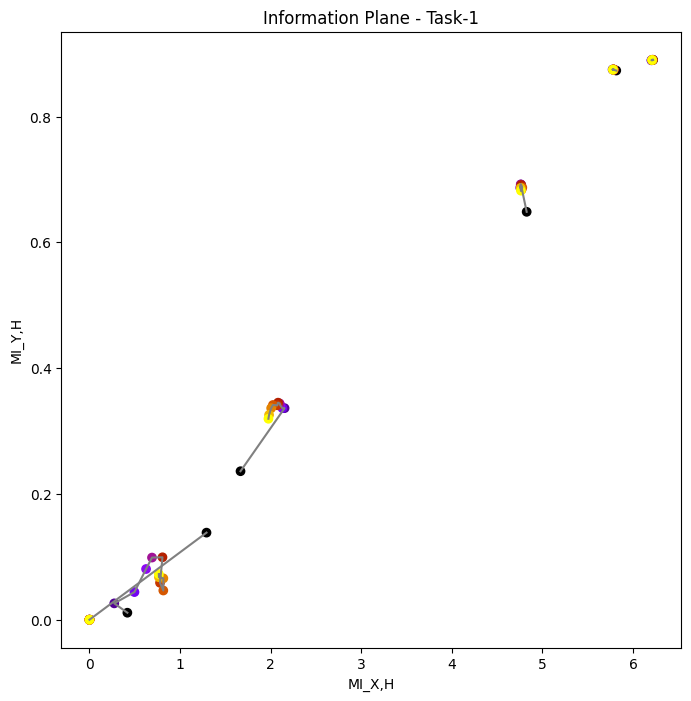

done!
        Train accuracy: 85.19514230091777
    Rehearsed on {1: 2047, 0: 2049}
    Testing Across Tasks
        Testing task: 1 / 1: 49%
        Testing global accuracy: 49%
Task: 2 / 3
    Online Mode
        Training... done!
        Train accuracy: 53.07346326836582
    Offline Mode
        Epoch: 1,

ValueError: ignored

In [12]:
#@title Run Experiment
# Model setup
model       = Model(numOutput = numOutput, storage_size = storage_size).to(device)
class_heads = {i : nn.Linear(3, len(tasks[0])).to(device) for i in range(len(tasks))}
loss_function = nn.NLLLoss()

# Test Setup
test_set_accuracy   = {}

# Mutual Information Setup
MI_loader   = get_MI_loader(tasks[0])
layers      = len(list(model.children())) + 1
MI_XH_tasks = torch.zeros(len(tasks), epochs+1, layers)
MI_YH_tasks = torch.zeros(len(tasks), epochs+1, layers)

# Run it
for taskNum in range(len(tasks)):
  print("Task:", taskNum+1, "/", len(tasks))
  print("    Online Mode")
  print("        Training... ", end="")
  model.train()
  model.online()
  parameters = list(model.parameters()) + list(class_heads[taskNum].parameters())
  optimizer = optim.SGD(parameters,
                        lr=offline_lr,
                        momentum=momentum,
                        weight_decay=weight_decay)
  online_loader, test_loader = get_loaders(tasks[taskNum])
  accuracy = 0
  N = 0
  for batch_idx, (images, labels) in enumerate(online_loader, start=1):
    images, labels = images.to(device), labels.to(device)
    # forward pass
    h1, h2, h3, h4, h5 = model(images)
    h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)

    loss = loss_function(h6, labels)

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # check if predicted labels are equal to true labels
    predicted_labels = torch.argmax(h6,dim=1)
    accuracy += torch.sum((predicted_labels==labels).float()).item()
    N += images.shape[0]
    model.update_storage(images, labels)
  print("done!")
  print("        Train accuracy:", 100. * accuracy/N)

  ### Calculate Mutual Information  Online Phase ###

  MI_XH, MI_YH = compute_mutual_information(model, class_heads, taskNum, MI_loader)
  MI_XH_tasks[taskNum, 0] = MI_XH
  MI_YH_tasks[taskNum, 0] = MI_YH

  print("    Offline Mode")
  model.train()
  model.offline()
  parameters = list(model.parameters()) + list(class_heads[taskNum].parameters())
  optimizer = optim.SGD(parameters,
                        lr=offline_lr,
                        momentum=momentum,
                        weight_decay=weight_decay)


  print("        Epoch: ", end="")
  for epoch in range(1, epochs+1):
    print(str(epoch) + ",", end="")
    #
    for localTaskNum, task in enumerate(tasks[:taskNum+1]):
      offline_loader = torch.utils.data.DataLoader(model.storage.get_data_by_task(task),
                                                    batch_size=batch_size, shuffle=True, drop_last=True)

      for batch_idx, (images, labels) in enumerate(offline_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5 = model(images)
        h6 = F.log_softmax(class_heads[localTaskNum](h5), dim = 1)
        loss = loss_function(h6, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]
        model.update_storage(images, labels)


    ### Calculate Mutual Information  Offline Phase ###

    MI_XH, MI_YH = compute_mutual_information(model, class_heads, taskNum, MI_loader)
    MI_XH_tasks[taskNum, epoch] = MI_XH
    MI_YH_tasks[taskNum, epoch] = MI_YH

  # plot results at the end of each task
  plt.figure()
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xlabel('MI_X,H')
  ax.set_ylabel('MI_Y,H')
  title = ax.set_title(f'Information Plane - Task-{taskNum+1}')
  cmap = plt.get_cmap('gnuplot', epochs+1)
  colors = [cmap(i) for i in np.linspace(0, 1, epochs+1)]
  ax.plot(MI_XH_tasks[taskNum], MI_YH_tasks[taskNum], '-', color='gray')
  for layer in range(layers):
      im = ax.scatter(MI_XH_tasks[taskNum, :,layer], MI_YH_tasks[taskNum, :,layer], c=colors)

  plt.show()

  print("done!")
  print("        Train accuracy:", 100. * accuracy/N)
  print("    Rehearsed on", model.storage)
  print("    Testing Across Tasks")
  overall, specific = test_tasks(model, class_heads, tasks[:taskNum+1])
  test_set_accuracy[taskNum] = specific

In [ ]:
#@title Compute Forgetting Metrics
ave_accuracy        = []
ave_inc_accuracy    = []
forgetting_measure  = []
backward_transfer   = []

# Compute average accuracy
for taskNum in range(len(tasks)):
    ave_accuracy.append(0)
    for testTaskNum in range(taskNum+1):
      ave_accuracy[-1] += test_set_accuracy[taskNum][testTaskNum]
    ave_accuracy[-1] = ave_accuracy[-1] / (taskNum+1)

# Compute average incremental accuracy
for taskNum in range(len(tasks)):
    ave_inc_accuracy.append(0)
    for testTaskNum in range(taskNum+1):
      ave_inc_accuracy[-1] += ave_accuracy[testTaskNum]
    ave_inc_accuracy[-1] = ave_inc_accuracy[-1] / (taskNum+1)

# Compute forgetting measure
for taskNum in range(1,len(tasks)):
    forgetting_measure.append(0)
    for testTaskNum in range(taskNum):
      f = -math.inf
      for i in range(testTaskNum, taskNum):
        if test_set_accuracy[i][testTaskNum] > f:
          f = test_set_accuracy[i][testTaskNum]
      forgetting_measure[-1] += f - test_set_accuracy[taskNum][testTaskNum]
    forgetting_measure[-1] = forgetting_measure[-1] / taskNum

# Compute backward transfer
for taskNum in range(1, len(tasks)):
    backward_transfer.append(0)
    for testTaskNum in range(taskNum):
      backward_transfer[-1] += test_set_accuracy[taskNum][testTaskNum] - test_set_accuracy[testTaskNum][testTaskNum]
    backward_transfer[-1] = backward_transfer[-1] / taskNum

print("Average Accuracy:", ave_accuracy)
print("Average Incremental Accuracy:", ave_inc_accuracy)
print("Forgetting Measure:", forgetting_measure)
print("Backward Transfer:", backward_transfer)

In [ ]:
#@title Plot Results
# Plot average accuracy
plt.figure()
plt.title("Average Accuracy")
plt.plot(ave_accuracy)

# Plot average incremental accuracy
plt.figure()
plt.title("Average Incremental Accuracy")
plt.plot(ave_inc_accuracy)

# Plot forgetting measure
plt.figure()
plt.title("Forgetting Measure")
plt.plot(forgetting_measure)

# Plot backward transfer
plt.figure()
plt.title("Backward Transfer")
plt.plot(backward_transfer)

# Construct figure
plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('MI_X,H')
ax.set_ylabel('MI_Y,H')
title = ax.set_title('Information Plane')

# Construct task colour map (for dots)
cmap_dots = plt.get_cmap('gnuplot', len(tasks))
dot_colors = [cmap_dots(i) for i in np.arange(0, len(tasks))]

# Construct layer colour map (for lines)
cmap_lines = plt.get_cmap('tab10', layers)
line_colors = [cmap_lines(i) for i in np.arange(0, layers)]
for layer in range(layers):
    ax.plot(MI_XH_tasks[:,layer], MI_YH_tasks[:,layer], '-', color=line_colors[layer], label="Layer " + str(layer+1))
    im = ax.scatter(XH_data, YH_data, c=dot_colors)
ax.legend()